In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Load the dataset
df = pd.read_csv('climate_nasa.csv')

In [8]:
# Display basic info
print(df.head())

                       date  likesCount  \
0  2022-09-07T17:12:32.000Z           2   
1  2022-09-08T14:51:13.000Z           0   
2  2022-09-07T17:19:41.000Z           1   
3  2022-09-08T00:51:30.000Z           4   
4  2022-09-07T19:06:20.000Z          16   

                                         profileName  commentsCount  \
0  4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...            NaN   
1  518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...            NaN   
2  d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...            3.0   
3  37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...            NaN   
4  e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...           26.0   

                                                text  
0  Neat comparison I have not heard it before.\n ...  
1  An excellent way to visualise the invisible! T...  
2  Does the CO2/ghg in the troposphere affect the...  
3  excellent post! I defo feel the difference - o...  
4  Yes, and carbon dioxide does not har

In [9]:
df.shape

(522, 5)

In [10]:

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB
None


In [11]:
# Basic statistics
print(df.describe())

       likesCount  commentsCount
count  522.000000     244.000000
mean     4.720307       8.696721
std     12.053556      12.266176
min      0.000000       1.000000
25%      0.000000       2.000000
50%      1.000000       5.000000
75%      4.000000      10.000000
max    126.000000      93.000000


In [12]:
# Check for missing values
print(df.isnull().sum())

date               0
likesCount         0
profileName        0
commentsCount    278
text              18
dtype: int64


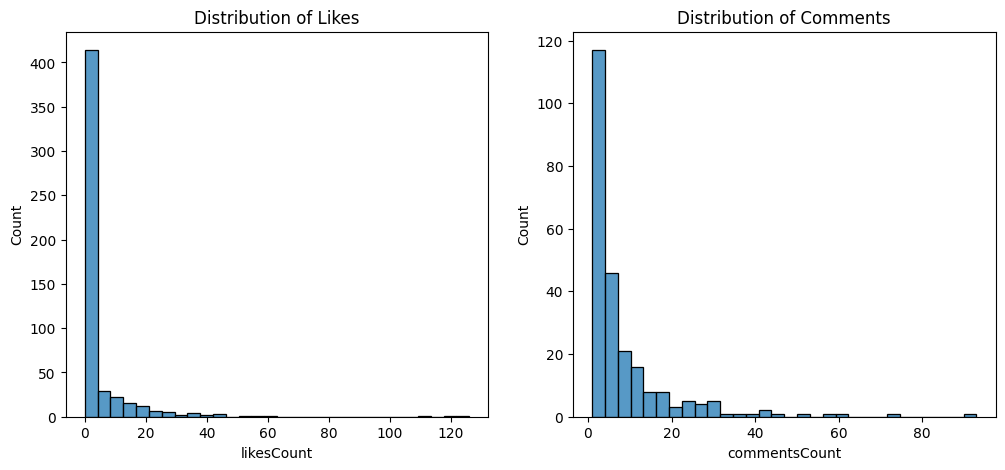

/tmp/ipython-input-447462764.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M').size().plot(title='Posts Over Time')


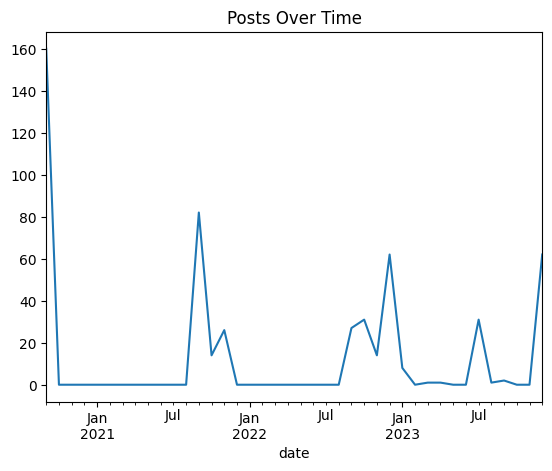

In [13]:
# Plot distribution of likes and comments
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['likesCount'], bins=30)
plt.title('Distribution of Likes')

plt.subplot(1, 2, 2)
sns.histplot(df['commentsCount'].dropna(), bins=30)
plt.title('Distribution of Comments')
plt.show()

# Time series of posts
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.resample('M').size().plot(title='Posts Over Time')
plt.show()

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
# Text length
df['text_length'] = df['text'].apply(lambda x: len(str(x)))

# Word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Sentiment analysis
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

df['sentiment'] = df['text'].apply(get_sentiment)

# Time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error

# Create target for classification (high engagement)
median_likes = df['likesCount'].median()
df['high_engagement'] = (df['likesCount'] > median_likes).astype(int)

# Vectorize text
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df['cleaned_text'].fillna('')) # Fill NaN with empty string

# Reset index to ensure proper concatenation
df_reset = df.reset_index(drop=True)

# Combine features
# Combine features
X = pd.concat([
    pd.DataFrame(X_text.toarray(), columns=[f"tfidf_{i}" for i in range(X_text.shape[1])]),
    df_reset[['text_length', 'word_count', 'sentiment', 'hour', 'day_of_week', 'month']]
], axis=1)

# Classification model
y_class = df_reset['high_engagement']
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Regression model (for comments)
y_reg = df_reset['commentsCount'].fillna(0)  # Fill NA comments with 0
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_reg, y_train_reg)

RandomForestRegressor(random_state=42)

In [17]:
# Classification evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Regression evaluation
y_pred_reg = reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"Mean Squared Error: {mse}")
print(f"RMSE: {mse**0.5}")

# Feature importance
feature_importances = pd.DataFrame(
    clf.feature_importances_,
    index = X.columns,
    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(10))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77        70
           1       0.52      0.37      0.43        35

    accuracy                           0.68       105
   macro avg       0.62      0.60      0.60       105
weighted avg       0.66      0.68      0.66       105

Mean Squared Error: 49.17653809523809
RMSE: 7.012598526597547
             importance
text_length    0.063430
word_count     0.046104
hour           0.045429
day_of_week    0.029481
sentiment      0.023755
tfidf_173      0.022389
tfidf_579      0.020832
tfidf_816      0.019653
month          0.017703
tfidf_157      0.016583


/tmp/ipython-input-2763832498.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_over_time = df['sentiment'].resample('M').mean()


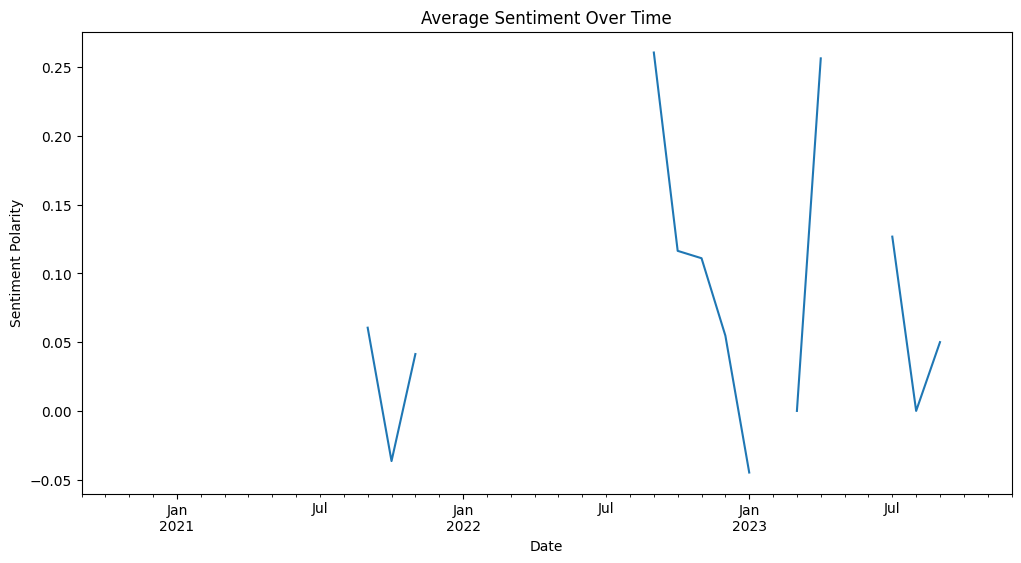

In [18]:
# Resample sentiment by month
sentiment_over_time = df['sentiment'].resample('M').mean()

plt.figure(figsize=(12, 6))
sentiment_over_time.plot()
plt.title('Average Sentiment Over Time')
plt.ylabel('Sentiment Polarity')
plt.xlabel('Date')
plt.show()

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize text for LDA
cv = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
dtm = cv.fit_transform(df['cleaned_text'])

# Create LDA model
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(dtm)

# Display topics
for index, topic in enumerate(LDA.components_):
    print(f"TOP 15 WORDS FOR TOPIC #{index}")
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print("\n")

TOP 15 WORDS FOR TOPIC #0
['scientist', 'think', 'ice', 'real', 'dont', 'year', 'science', 'know', 'planet', 'global', 'would', 'warming', 'people', 'climate', 'change']


TOP 15 WORDS FOR TOPIC #1
['warming', 'greenhouse', 'going', 'getting', 'time', 'one', 'planet', 'human', 'nasa', 'data', 'temperature', 'global', 'change', 'year', 'climate']


TOP 15 WORDS FOR TOPIC #2
['chart', 'people', 'hope', 'like', 'man', 'warming', 'save', 'global', 'pollution', 'one', 'energy', 'que', 'nasa', 'need', 'de']


TOP 15 WORDS FOR TOPIC #3
['ice', 'age', 'warming', 'move', 'dont', 'change', 'know', 'every', 'think', 'temperature', 'go', 'year', 'back', 'earth', 'climate']


TOP 15 WORDS FOR TOPIC #4
['warming', 'would', 'billion', 'ton', 'rise', 'foot', 'sea', 'water', 'dioxide', 'year', 'level', 'earth', 'atmosphere', 'carbon', 'co2']




In [20]:
import os

# Check current directory
print("Current directory:", os.getcwd())

# List files in directory
print("Files in directory:", os.listdir())

Current directory: /content
Files in directory: ['.config', 'climate_nasa.csv', 'sample_data']


In [21]:
import pickle

# Save the classifier model
with open('climate_nasa', 'wb') as f:
    pickle.dump(clf, f)

# Save the regression model
with open('clf_model.pkl', 'wb') as f:
    pickle.dump(reg, f)

In [22]:
import os

# Check current directory
print("Current directory:", os.getcwd())

# List files in directory
print("Files in directory:", os.listdir())

Current directory: /content
Files in directory: ['.config', 'clf_model.pkl', 'climate_nasa.csv', 'climate_nasa', 'sample_data']


In [23]:
from joblib import dump, load

# Save models
dump(clf, 'clf_model.joblib')
dump(reg, 'reg_model.joblib')

# Load models
clf = load('clf_model.joblib')
reg = load('reg_model.joblib')

In [24]:
import os

model_path = 'clf_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        clf = pickle.load(f)
else:
    print(f"Error: {model_path} not found. Train and save the model first.")

In [25]:
import pickle

# Fit the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df['cleaned_text'].fillna(''))

# Save the TF-IDF vectorizer
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [26]:
import os
print(os.listdir())  # Should show 'tfidf.pkl' in the output

['.config', 'clf_model.joblib', 'clf_model.pkl', 'reg_model.joblib', 'tfidf.pkl', 'climate_nasa.csv', 'climate_nasa', 'sample_data']


In [27]:
with open('tfidf.pkl', 'rb') as f:
    tfidf = pickle.load(f)

In [28]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
from flask import Flask, Response

app = Flask(__name__)

@app.route('/')
def home():
    response = Response("Hello World!")
    response.headers['ngrok-skip-browser-warning'] = 'true'  # Skip warning
    return response

In [30]:
import requests

url = "https://bfac6e9e808c.ngrok-free.app"
headers = {"User-Agent": "CustomAgent/1.0"}
response = requests.get(url, headers=headers)  # No warning